In [3]:
import numpy as np
import tensorflow as tf
import math, cv2, os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from random import randint
from sklearn.utils import shuffle
%load_ext tensorboard
%tensorboard --logdir logs
print(tf.__version__)

train_dataset_path = "/app/train"
val_dataset_path = "/app/validation"

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dataset_path,
        target_size=(150, 150),
        color_mode='rgb',
        batch_size=32,
        shuffle=True,
        seed=None,
        class_mode="categorical")

val_generator = val_datagen.flow_from_directory(
        val_dataset_path,
        target_size=(150, 150),
        color_mode='rgb',
        batch_size=32,
        shuffle=True,
        seed=None,
        class_mode="categorical")

Launching TensorBoard...

1.14.0
Found 4800 images belonging to 10 classes.
Found 1200 images belonging to 10 classes.


In [7]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(150, 150, 3),
                                               include_top=False)
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10, activation='sigmoid')
])
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Number of layers in the base model:  155
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                12810     
Total params: 2,270,794
Trainable params: 1,875,402
Non-trainable params: 395,392
_________________________________________________________________


In [8]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks_max_acc = myCallback()

def get_images(directory):
    Images = []
        
    for image_file in all_image_paths:
        image=cv2.imread(directory+'/'+image_file)
        image=cv2.resize(image,(150,150))
        Images.append(image)
    
    return shuffle(Images,random_state=817328462)

tensorboard_callback = tf.keras.callbacks.TensorBoard("logs")

In [10]:
history = model.fit_generator(
      train_generator,
      epochs=30,
      validation_data=val_generator,
      callbacks=[callbacks_max_acc, tensorboard_callback])

Epoch 1/30
150/150 [==============================] - 308s 2s/step - loss: 0.1722 - acc: 0.9424 - val_loss: 0.4997 - val_acc: 0.7727
Epoch 2/30
150/150 [==============================] - 355s 2s/step - loss: 0.1223 - acc: 0.9616 - val_loss: 0.2728 - val_acc: 0.8920
Epoch 3/30
150/150 [==============================] - 288s 2s/step - loss: 0.0942 - acc: 0.9695 - val_loss: 0.1777 - val_acc: 0.9342
Epoch 4/30
150/150 [==============================] - 264s 2s/step - loss: 0.0739 - acc: 0.9770 - val_loss: 0.1388 - val_acc: 0.9493
Epoch 5/30
150/150 [==============================] - 265s 2s/step - loss: 0.0601 - acc: 0.9817 - val_loss: 0.1230 - val_acc: 0.9556
Epoch 6/30
150/150 [==============================] - 264s 2s/step - loss: 0.0480 - acc: 0.9863 - val_loss: 0.1186 - val_acc: 0.9573
Epoch 7/30
150/150 [==============================] - 265s 2s/step - loss: 0.0392 - acc: 0.9886 - val_loss: 0.1187 - val_acc: 0.9571
Epoch 8/30
149/150 [============================>.] - ETA: 1s - loss:

In [12]:
model.save('Mobilenet_30_epochs_150_imres_Model.h5')


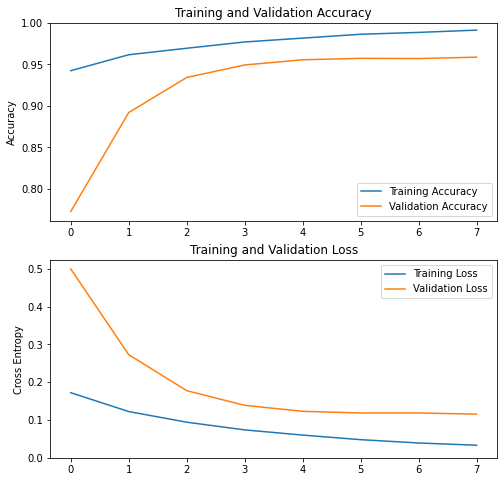

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()